<a href="https://colab.research.google.com/github/yeowul/git_dir/blob/master/22_05_17_day03_bpe_sentencepiece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전에 없는 단어의 문제

```
코로나바이러스는 2019년 12월 중국 우한에서 처음 발생한 뒤
전 세계로 확산된, 새로운 유형의 호흡기 감염 질환입니다.

→

<unk>는 2019년 12월 중국 <unk>에서 처음 발생한 뒤
전 세계로 확산된, 새로운 유형의 호흡기 감염 질환입니다.
```

 만약 위 문장을 영문으로 번역해야 한다면 어떨까요? 핵심인 단어 `코로나바이러스`와 `우한`을 모른다면 제대로 해낼 수 있을 리가 없습니다. 이를 **OOV(Out-Of-Vocabulary)** 문제라고 합니다. 이처럼 **새로 등장한(본 적 없는) 단어에 대해 약한 모습**을 보일 수밖에 없는 기법들이기에, 이를 해결하고자 하는 시도들이 있었습니다. 그리고 그것이 우리가 다음 스텝에서 배울, ***Wordpiece Model***이죠!

*Wordpiece Model(WPM)* 은 우리가 접한 적이 있는 아이디어를 기반으로 만들어졌습니다. 두 단어 `preview`와 `predict`를 보면 접두어인 `pre`가 공통되고 있죠? `pre`가 들어간 단어는 주로 **"미리", "이전의"** 와 연계되는 의미를 가지고 있습니다. 컴퓨터도 두 단어를 따로 볼 게 아니라 `pre+view`와 `pre+dict`로 본다면 학습을 더 잘 할 수 있지 않을까요?

이처럼 한 단어를 여러 개의 Subword의 집합으로 보는 방법이 WPM입니다. WPM의 원리를 알기 전, 먼저 알아야 할 것이 바로 **Byte Pair Encoding(BPE)** 입니다.

# Byte Pair Encoding(BPE)

---

BPE 알고리즘이 고안된 것은 1994년입니다. 그때는 자연어 처리에 적용하기 위해서가 아니라 데이터 압축을 위해서 생겨났었죠. 데이터에서 **가장 많이 등장하는 바이트 쌍(Byte Pair)** 을 새로운 단어로 치환하여 압축하는 작업을 반복하는 방식으로 동작합니다. 예시는 아래와 같습니다.

```
aaabdaaabac # 가장 많이 등장한 바이트 쌍 "aa"를 "Z"로 치환합니다.
→ 
ZabdZabac   # "aa" 총 두 개가 치환되어 4바이트를 2바이트로 압축하였습니다.
Z=aa        # 그다음 많이 등장한 바이트 쌍 "ab"를 "Y"로 치환합니다.
→ 
ZYdZYac     # "ab" 총 두 개가 치환되어 4바이트를 2바이트로 압축하였습니다.
Z=aa        # 여기서 작업을 멈추어도 되지만, 치환된 바이트에 대해서도 진행한다면
Y=ab        # 가장 많이 등장한 바이트 쌍 "ZY"를 "X"로 치환합니다.
→ 
XdXac
Z=aa
Y=ab
X=ZY       # 압축이 완료되었습니다!
```

아주 직관적인 알고리즘이죠? 이를 토큰화에 적용하자고 제안한 것은 2015년이었습니다. 모든 단어를 문자(바이트)들의 집합으로 취급하여 자주 등장하는 문자 쌍을 합치면, 접두어나 접미어의  의미를 캐치할 수 있고, 처음 등장하는 단어는 문자(알파벳)들의 조합으로 나타내어 **OOV 문제를 완전히 해결**할 수 있다는 것이죠!

비교적 최근의 기술을 소개해드리는 만큼 논문을 함께 첨부합니다.

- [Neural Machine Translation of Rare Words with Subword Units](https://arxiv.org/pdf/1508.07909.pdf)

위 논문은 Python 소스 코드를 함께 제공해 주어 간편하게 실습을 해 볼 수 있습니다. 논문에서 제공해 주는 예제로 동작 방식을 자세히 들여다보죠!

# n-grams

- 유니그램 (uni-gram)
- 바이그램 (bi-gram)
- 트라이그램 (tri-gram)  
나는 학교에 가서 공부를 합니다.

In [ ]:
def n_grams(text, n):
    return [text[i:i+n] for i in range(len(text)-n+1)]

cleaned= ['mary', ',', "n't", 'slap', 'green', 'witch', '.']

print(n_grams(cleaned, 1))

[['mary'], [','], ["n't"], ['slap'], ['green'], ['witch'], ['.']]


# BPE Algorithm

In [ ]:
import re, collections

In [ ]:
num_merges = 10 # BPE를 몇 회 수행할 것지 정함.

```
# BPE corpus
corpus = """
low lower newest widest
low lower newest widest
low       newest widest
low       newest
low       newest
          newest
"""
```

In [ ]:
dictionary = {'l o w </w>' : 5,
              'l o w e r </w>' : 2,
              'n e w e s t </w>' : 6,
              'w i d e s t </w>' :3
}

In [ ]:
def get_stats(dictionary):

    """
    단어 사전을 불러와
    단어는 공백 단위로 쪼개어 문자 list를 만들고
    빈도수와 쌍을 이루게 합니다. (symbols)
    """
    
  # 유니그램의 pair들의 빈도수를 카운트
    pairs = collections.defaultdict(int)
    for word, freq in dictionary.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    print('현재 pair들의 빈도수 :', dict(pairs))
    return pairs

In [ ]:
def merge_dictionary(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

In [ ]:
bpe_codes = {}
bpe_codes_reverse = {}
for i in range(num_merges):
    print(">> Step {0}".format(i+1))
    pairs = get_stats(dictionary)
    best = max(pairs, key=pairs.get)
    dictionary = merge_dictionary(best, dictionary)

    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best

    print("new merge: {}".format(best))
    print("dictionary: {}".format(dictionary))

>> Step 1
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 8, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('e', 's'): 9, ('s', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'e'): 3}
new merge: ('e', 's')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}
>> Step 2
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'es'): 6, ('es', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'es'): 3}
new merge: ('es', 't')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}
>> Step 3
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est'): 6, ('est', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est'): 3}
new merge: ('est', '</w>')
dictiona

In [ ]:
print(bpe_codes)

{('e', 's'): 0, ('es', 't'): 1, ('est', '</w>'): 2, ('l', 'o'): 3, ('lo', 'w'): 4, ('n', 'e'): 5, ('ne', 'w'): 6, ('new', 'est</w>'): 7, ('low', '</w>'): 8, ('w', 'i'): 9}


# OOV 대처하기

만일 `lowest`라는 처음 보는 단어가 등장하더라도, 위 알고리즘을 따르면 어느 정도 의미가 파악된 `low`와 `est`의 결합으로 표현할 수 있습니다. 또 BPE의 놀라운 점은 아무리 큰 데이터도 원하는 크기로 OOV 문제없이 사전을 정의할 수 있다는 것입니다. 극단적으로 생각했을 때 알파벳 26개와 특수문자, 문장부호를 아무리 추가해도 100개 이내로 사전을 정의할 수 있죠.(물론 그러면 안 됩니다!!)

Embedding 레이어는  **단어의 개수 x Embedding 차원 수** 의 Weight를 생성하기 때문에 단어의 개수가 줄어드는 것은 곧 메모리의 절약으로 이어집니다. 많은 데이터가 곧 정확도로 이어지기 때문에 이런 기여는 굉장히 의미가 있습니다!

하지만 아직도! 완벽하다고는 할 수 없습니다. 만약 수많은 데이터를 사용해 만든 BPE 사전으로 모델을 학습시키고 문장을 생성하게 했다고 합시다. 그게 `[i, am, a, b, o, y, a, n, d, you, are, a, gir, l]`이라면, 어떤 기준으로 이들을 결합해서 문장을 복원하죠? 몽땅 한꺼번에 합쳤다간 끔찍한 일이 벌어질 것만 같습니다... 

In [ ]:
def get_pairs(word):
  pairs = set()
  prev_char = word[0]
  for char in word[1:]:
    pairs.add((prev_char, char))
    prev_char = char
  return pairs

In [ ]:
orig = 'hi'
word = tuple(orig) + ('</w>',)
print(word)

('h', 'i', '</w>')


In [ ]:
def encode(orig):
  word = tuple(orig) + ('</w>',)
  print("__word split into characters:__ <tt>{}<tt>".format(word))

  pairs = get_pairs(word)

  if not pairs:
    return orig
  
  iteration = 0
  while True:
    iteration += 1
    print("__Iteration {}:__".format(iteration))

    print("Bigram in the word: {}".format(pairs))
    bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
    print("candidate for merging: {}".format(bigram))
    if bigram not in bpe_codes:
      print("__Candidate not in BPE merges, algorithm stops.__")
      break
    first, second = bigram
    new_word = []
    i = 0
    while i < len(word):
      try:
        j = word.index(first, i)
        new_word.extend(word[i:j])
        i = j
      except:
        new_word.extend(word[i:])
        break

      if word[i] == first and i < len(word)-1 and word[i+1] == second:
        new_word.append(first+second)
        i += 2
      else:
        new_word.append(word[i])
        i += 1
    new_word = tuple(new_word)
    word = new_word
    print("word after merging : {}".format(word))
    if len(word) == 1:
      break
    else:
      pairs = get_pairs(word)
  
  # 특별토큰인 </w>는 출력하지 않는다.
  if word[-1] == '</w>':
    word = word[:-1]
  elif word[-1].endswith('</w>'):
    word = word[:-1] + (word[-1].replace('</w>', ''), )
  return word

In [ ]:
encode("loki")

__word split into characters:__ <tt>('l', 'o', 'k', 'i', '</w>')<tt>
__Iteration 1:__
Bigram in the word: {('o', 'k'), ('k', 'i'), ('i', '</w>'), ('l', 'o')}
candidate for merging: ('l', 'o')
word after merging : ('lo', 'k', 'i', '</w>')
__Iteration 2:__
Bigram in the word: {('i', '</w>'), ('k', 'i'), ('lo', 'k')}
candidate for merging: ('i', '</w>')
__Candidate not in BPE merges, algorithm stops.__


('lo', 'k', 'i')

In [ ]:
encode("lowest")

__word split into characters:__ <tt>('l', 'o', 'w', 'e', 's', 't', '</w>')<tt>
__Iteration 1:__
Bigram in the word: {('t', '</w>'), ('e', 's'), ('s', 't'), ('o', 'w'), ('w', 'e'), ('l', 'o')}
candidate for merging: ('e', 's')
word after merging : ('l', 'o', 'w', 'es', 't', '</w>')
__Iteration 2:__
Bigram in the word: {('t', '</w>'), ('l', 'o'), ('w', 'es'), ('o', 'w'), ('es', 't')}
candidate for merging: ('es', 't')
word after merging : ('l', 'o', 'w', 'est', '</w>')
__Iteration 3:__
Bigram in the word: {('est', '</w>'), ('w', 'est'), ('o', 'w'), ('l', 'o')}
candidate for merging: ('est', '</w>')
word after merging : ('l', 'o', 'w', 'est</w>')
__Iteration 4:__
Bigram in the word: {('w', 'est</w>'), ('o', 'w'), ('l', 'o')}
candidate for merging: ('l', 'o')
word after merging : ('lo', 'w', 'est</w>')
__Iteration 5:__
Bigram in the word: {('lo', 'w'), ('w', 'est</w>')}
candidate for merging: ('lo', 'w')
word after merging : ('low', 'est</w>')
__Iteration 6:__
Bigram in the word: {('low', 

('low', 'est')

In [ ]:
encode("lowing")

__word split into characters:__ <tt>('l', 'o', 'w', 'i', 'n', 'g', '</w>')<tt>
__Iteration 1:__
Bigram in the word: {('l', 'o'), ('i', 'n'), ('n', 'g'), ('w', 'i'), ('o', 'w'), ('g', '</w>')}
candidate for merging: ('l', 'o')
word after merging : ('lo', 'w', 'i', 'n', 'g', '</w>')
__Iteration 2:__
Bigram in the word: {('i', 'n'), ('n', 'g'), ('w', 'i'), ('lo', 'w'), ('g', '</w>')}
candidate for merging: ('lo', 'w')
word after merging : ('low', 'i', 'n', 'g', '</w>')
__Iteration 3:__
Bigram in the word: {('low', 'i'), ('g', '</w>'), ('i', 'n'), ('n', 'g')}
candidate for merging: ('low', 'i')
__Candidate not in BPE merges, algorithm stops.__


('low', 'i', 'n', 'g')

In [ ]:
encode("Lowing")

__word split into characters:__ <tt>('L', 'o', 'w', 'i', 'n', 'g', '</w>')<tt>
__Iteration 1:__
Bigram in the word: {('L', 'o'), ('g', '</w>'), ('i', 'n'), ('w', 'i'), ('o', 'w'), ('n', 'g')}
candidate for merging: ('w', 'i')
word after merging : ('L', 'o', 'wi', 'n', 'g', '</w>')
__Iteration 2:__
Bigram in the word: {('L', 'o'), ('o', 'wi'), ('wi', 'n'), ('g', '</w>'), ('n', 'g')}
candidate for merging: ('L', 'o')
__Candidate not in BPE merges, algorithm stops.__


('L', 'o', 'wi', 'n', 'g')

In [ ]:
encode("highing")

__word split into characters:__ <tt>('h', 'i', 'g', 'h', 'i', 'n', 'g', '</w>')<tt>
__Iteration 1:__
Bigram in the word: {('h', 'i'), ('g', '</w>'), ('i', 'n'), ('i', 'g'), ('n', 'g'), ('g', 'h')}
candidate for merging: ('h', 'i')
__Candidate not in BPE merges, algorithm stops.__


('h', 'i', 'g', 'h', 'i', 'n', 'g')

# WordPiece Model(WPM)

이에 구글에서 BPE를 변형해 제안한 알고리즘이 바로 WPM입니다. WPM은 BPE에 대해 **두 가지 차별성**을 가집니다.

1. 공백 복원을 위해 단어의 시작 부분에 언더바 _ 를 추가합니다.
2. 빈도수 기반이 아닌 가능도(Likelihood)를 증가시키는 방향으로 문자 쌍을 합칩니다.

첫 번째 문항은 아주 쉬운 내용으로, 앞서 사용한 예문을 빌리면 `[_i, _am, _a, _b, o, y, _a, n, d, _you, _are, _a, _gir, l]`로 토큰화를 한다는 것입니다. 이렇게 하면 문장을 복원하는 과정이 **1) 모든 토큰을 합친 후, 2) 언더바 _를 공백으로 치환**으로 마무리되어 간편하죠.

두 번째 문항은 다소 난해하게 다가올 수도 있습니다. 직관적인 이해를 얻고 넘어가는 것을 목표로 하죠. 본 내용은 아래 논문 3절과 4절에 자세하게 나와 있습니다.
   
- [JAPANESE AND KOREAN VOICE SEARCH](https://static.googleusercontent.com/media/research.google.com/ko//pubs/archive/37842.pdf)

(여기서 잠깐)
구글에서 이 기법을 한국어, 일본어 텍스트 처리를 위해 고려했다는 사실이 흥미롭지 않나요? 이 점은 2가지를 시사합니다. 
- 조사, 어미 등의 활용이 많고 복잡한 한국어 같은 모델의 토크나이저로 WPM이 좋은 대안이 될 수 있다.
- WPM은 어떤 언어든 무관하게 적용 가능한 language-neutral하고 general한 기법이다. 한국어 형태소 분석기처럼 한국어에만 적용 가능한 기법보다 훨씬 활용도가 크다.  

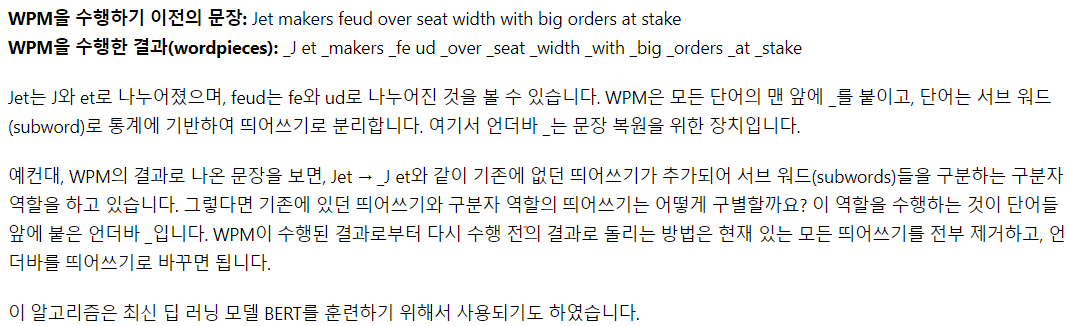

# SentencePiece

토큰화의 끝판왕으로 보이는 이 WPM은 아쉽게도 공개되어 있지는 않습니다. 대신에 구글의 *SentencePiece* 라이브러리를 통해 고성능의 BPE를 사용할 수 있습니다! *SentencePiece*에는 전처리 과정도 포함되어 있어서, 데이터를 따로 정제할 필요가 없어 간편하기까지 합니다. 따라서 아래 깃허브 페이지에 방문해 사용법을 간단히 눈으로 봐두도록 하죠!  아마 다음 프로젝트 노드에서는 *SentencePiece* 라이브러리를 적극적으로 활용하는 실습을 진행하게 될 것입니다. 

- [google/sentencepiece](https://github.com/google/sentencepiece)

이제 우리는 어떤 언어에도 OOV 발생 우려 없이 안정적으로 활용할 수 있는 멋진 토크나이징 기술을 확보했습니다. 이제는 컴퓨터가 단어사전을 안심하고 활용할 수 있겠군요!

하지만 아직 우리는 제대로 된 단어의 분산 표현을 얻는 법을 제대로 다루지는 않았습니다. 이쯤에서 이런 고민이 생기게 됩니다. 한국어라면 `자동차`를 `_자동 / 차` 로 분리되는데... 속성이 아무리 추상적이래도 보기에 `차`가 마시는 차인지, 달리는 차인지 도통 알 수가 없죠? 게다가 설령 토큰화가 완벽하다고 해도, `남자`가 `[-1, 0]`인지 `[1, 0]`인지는 컴퓨터 입장에서는 알 도리가 없습니다.

Embedding 레이어는 선언 즉시 랜덤한 실수로 Weight 값을 채우고, 학습을 진행하며 적당히 튜닝해가는 방식으로 속성을 맞춰가지만 이는 뭔가 찜찜합니다. 토큰들이 멋지게 의미를 갖게 하는 방법은 없을까요?

# IMDB로 센텐스피스 적용하기

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 8.7 MB/s 


In [ ]:
import sentencepiece as spm
import pandas as pd
import urllib.request
import csv

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x7fe22b4439d0>)

In [ ]:
train_df = pd.read_csv('IMDb_Reviews.csv')

In [ ]:
train_df.head() # 상위 5개를 출력해주세요.

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [ ]:
print("리뷰 갯수 :", len(train_df))

리뷰 갯수 : 50000


In [ ]:
with open('imdb_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_df['review']))

```
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰
```
```
spm.SentencePieceTrainer.Train('--input=imdb_review.txt --model_prefix=imdb --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')
```

In [ ]:
corpus = 'imdb_review.txt' # 입력 corpus
prefix = 'imdb' # 저장할 단어장 이름
vocab_size = 5000
spm.SentencePieceTrainer.Train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size}" +
    "--model_type=bpe" +
    "--max_sentence_length=999999" #문장 최대 길이
)

In [ ]:
vocab_list = pd.read_csv('imdb.vocab', sep='\t', header = None, quoting=csv.QUOTE_NONE)
vocab_list.sample(10)

,0,1
2840,▁Va,-10.13190
3452,▁hype,-10.42780
4807,▁explode,-11.27620
3890,▁fur,-10.67640
2154,iness,-9.76961
3428,▁curious,-10.41880
1433,▁cause,-9.27165
4533,▁prince,-11.07510
3972,▁trial,-10.71840
2107,▁casting,-9.74218


In [ ]:
len(vocab_list)

5000

In [ ]:
sp = spm.SentencePieceProcessor()
vocab_file = 'imdb.model'
sp.load(vocab_file)

True

In [ ]:
lines = [
         "I didn't at all think of it this way.",
         "I have waited a long time for someone to film"
]

for line in lines:
    print(line)
    print(sp.encode_as_pieces(line)) # 서브워드 시퀀스 변환
    print(sp.encode_as_ids(line)) # 정수 시퀀스 변환
    print()

I didn't at all think of it this way.
['▁I', '▁didn', "'", 't', '▁at', '▁all', '▁think', '▁of', '▁it', '▁this', '▁way', '.']
[16, 250, 11, 15, 56, 52, 146, 9, 17, 20, 139, 6]

I have waited a long time for someone to film
['▁I', '▁have', '▁wait', 'ed', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film']
[16, 45, 1401, 27, 7, 338, 82, 28, 543, 10, 30]



In [ ]:
sp.GetPieceSize() # 단어집합의 크기

5000

In [ ]:
sp.IdToPiece(120) # 정수로부터 매핑되는 서브워드 변환

'▁will'

In [ ]:
sp.PieceToId('▁will') # 대문자 I, 서브워드로부터 매핑되는 정수로 변환

120

In [ ]:
sp.DecodeIds([16, 45, 1401, 27, 7, 338, 82, 28, 543, 10, 30]) 
# 정수 시퀀스를 sp.DecodeIds의 정수 시퀀스에 입력

'I have waited a long time for someone to film'

In [ ]:
sp.DecodePieces(['▁I', '▁have', '▁wait', 'ed', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film'])
# 서브워드 시퀀스로부터 문장으로 변환

'I have waited a long time for someone to film'

In [ ]:
print(sp.encode('I have waited a long time for someone to film', out_type=str)) # subword 시퀀스
print(sp.encode('I have waited a long time for someone to film', out_type=int)) # 정수 시퀀스

['▁I', '▁have', '▁wait', 'ed', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film']
[16, 45, 1401, 27, 7, 338, 82, 28, 543, 10, 30]


# 네이버 영화리뷰로 센텐스피스 적용하기

In [ ]:
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7fe22ae08650>)

In [ ]:
naver_df = pd.read_table('ratings.txt')
naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
print('리뷰 갯수 :', len(naver_df))

리뷰 갯수 : 200000


In [ ]:
print(naver_df.isnull().values.any()) # NULL값 존재 확인

True


In [ ]:
# Null값이 존재하는 행 제거
naver_df = naver_df.dropna(how='any')

In [ ]:
print(naver_df.isnull().values.any()) # NULL값 존재 확인

False


In [ ]:
print('리뷰 갯수 :', len(naver_df))

리뷰 갯수 : 199992


In [ ]:
# Quiz 1
# naver data 'document'컬럼을 txt에 새로 만드세요.

with open('naver_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(naver_df['document']))

In [ ]:
# Quiz2
# sentencePieceTrainer로 학습

spm.SentencePieceTrainer.Train('--input=naver_review.txt --model_prefix=naver --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')

In [ ]:
# Quiz3
# vocab을 불러오기

vocab_list = pd.read_csv('naver.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.head(10)

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,▁그,-6


In [ ]:
# Quiz4
# vocab모델이 있는지 확인
sp = spm.SentencePieceProcessor()
vocab_file = "naver.model"
sp.load(vocab_file)

True

In [ ]:
lines = [
         "뭐 이딴 것도 영화냐.",
         "진짜 최고의 영화입니다ㅋㅋ",
]

for line in lines:
    print(line)
    print(sp.encode_as_pieces(line)) # 서브워드로 변환
    print(sp.encode_as_ids(line)) # 정수 시퀀스로 변환
    print()

뭐 이딴 것도 영화냐.
['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.']
[132, 966, 1296, 2590, 3276]

진짜 최고의 영화입니다ㅋㅋ
['▁진짜', '▁최고의', '▁영화입니다', 'ᄏᄏ']
[54, 200, 821, 12]



In [ ]:
sp.GetPieceSize()

5000

In [ ]:
sp.IdToPiece(120)

'▁공'

In [ ]:
sp.PieceToId('▁공')

120

In [ ]:
sp.DecodeIds([132, 966, 1296, 2590, 3276])

'뭐 이딴 것도 영화냐.'

In [ ]:
sp.DecodePieces(['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.'])

'뭐 이딴 것도 영화냐.'

In [ ]:
print(sp.encode('진짜 최고의 영화입니다ㅋㅋ', out_type=str))
print(sp.encode('진짜 최고의 영화입니다ㅋㅋ', out_type=int))

['▁진짜', '▁최고의', '▁영화입니다', 'ᄏᄏ']
[54, 200, 821, 12]


## 불용어

불용어 : 큰 의미가 없음에도 불구하고, 자주등장하지만, 큰 도움이 되지 않는 단어들

https://www.ranks.nl/stopwords/korean

In [ ]:
from nltk.corpus import stopwords # 불용어
from nltk.tokenize import word_tokenize # 단어 토크나이저
from konlpy.tag import Okt # 한국어 형태소 분석기

In [ ]:
raw_text = "A barber is a person. a barber is good person. a barber is huge person. he Knew A Secret! The Secret He Kept is huge secret. Huge secret. His barber kept his word. a barber kept his word. His barber kept his secret. But keeping and keeping such a huge secret to himself was driving the barber crazy. the barber went up a huge mountain."

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 37.2 MB/s 


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
okt = Okt()

example= "고기를 아무렇게나 구우려고 하면 안 돼. 고기라도 다 같은 게 아니거든. 예컨데 삼겹살을 구울 때는 중요한 게 있지."
stop_words = "를 아무렇게나 구 우려 고 안 돼 같은 게 구울 때 는"

stop_words = set(stop_words.split(' '))
word_tokens = okt.morphs(example)

print('불용어 제거 전 :', word_tokens)

result = [word for word in word_tokens if not word in stop_words]

print('불용어 제거 후 :', result)

불용어 제거 전 : ['고기', '를', '아무렇게나', '구', '우려', '고', '하면', '안', '돼', '.', '고기', '라도', '다', '같은', '게', '아니거든', '.', '예컨데', '삼겹살', '을', '구울', '때', '는', '중요한', '게', '있지', '.']
불용어 제거 후 : ['고기', '하면', '.', '고기', '라도', '다', '아니거든', '.', '예컨데', '삼겹살', '을', '중요한', '있지', '.']
